In [ ]:
#https://github.com/mlabonne/graph-neural-network-course/blob/main/2_Graph_Attention_Network.ipynb

In [2]:
import torch
# Numpy for matrices
import numpy as np
np.random.seed(0)


# Dataset

In [5]:
from torch_geometric.datasets import Planetoid


In [6]:
path = "/home/sire/phd/srz228573/benchmarking_datasets/baseline_model_dataset/gat"
dataset = Planetoid(root=path, name="CiteSeer")

In [8]:
data = dataset[0]
dataset[0]

Data(x=[3327, 3703], edge_index=[2, 9104], y=[3327], train_mask=[3327], val_mask=[3327], test_mask=[3327])

In [34]:
data.x, data.train_mask

(tensor([[0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         ...,
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.],
         [0., 0., 0.,  ..., 0., 0., 0.]]),
 tensor([ True,  True,  True,  ..., False, False, False]))

In [11]:
# Print information about the dataset
print(f'Dataset: {dataset}')
print('-------------------')
print(f'Number of graphs: {len(dataset)}')
print(f'Number of nodes: {data.x.shape[0]}')
print(f'Number of features: {dataset.num_features}')
print(f'Number of classes: {dataset.num_classes}')

Dataset: CiteSeer()
-------------------
Number of graphs: 1
Number of nodes: 3327
Number of features: 3703
Number of classes: 6


In [10]:
# Print information about the graph
print(f'\nGraph:')
print('------')
print(f'Edges are directed: {data.is_directed()}')
print(f'Graph has isolated nodes: {data.has_isolated_nodes()}')
print(f'Graph has loops: {data.has_self_loops()}')


Graph:
------
Edges are directed: False
Graph has isolated nodes: True
Graph has loops: False


In [12]:
from torch_geometric.utils import remove_isolated_nodes

isolated = (remove_isolated_nodes(data['edge_index'])[2] == False).sum(dim=0).item()
print(f'Number of isolated nodes = {isolated}')

Number of isolated nodes = 48


## Plot dataset

In [15]:
import matplotlib.pyplot as plt
import networkx as nx

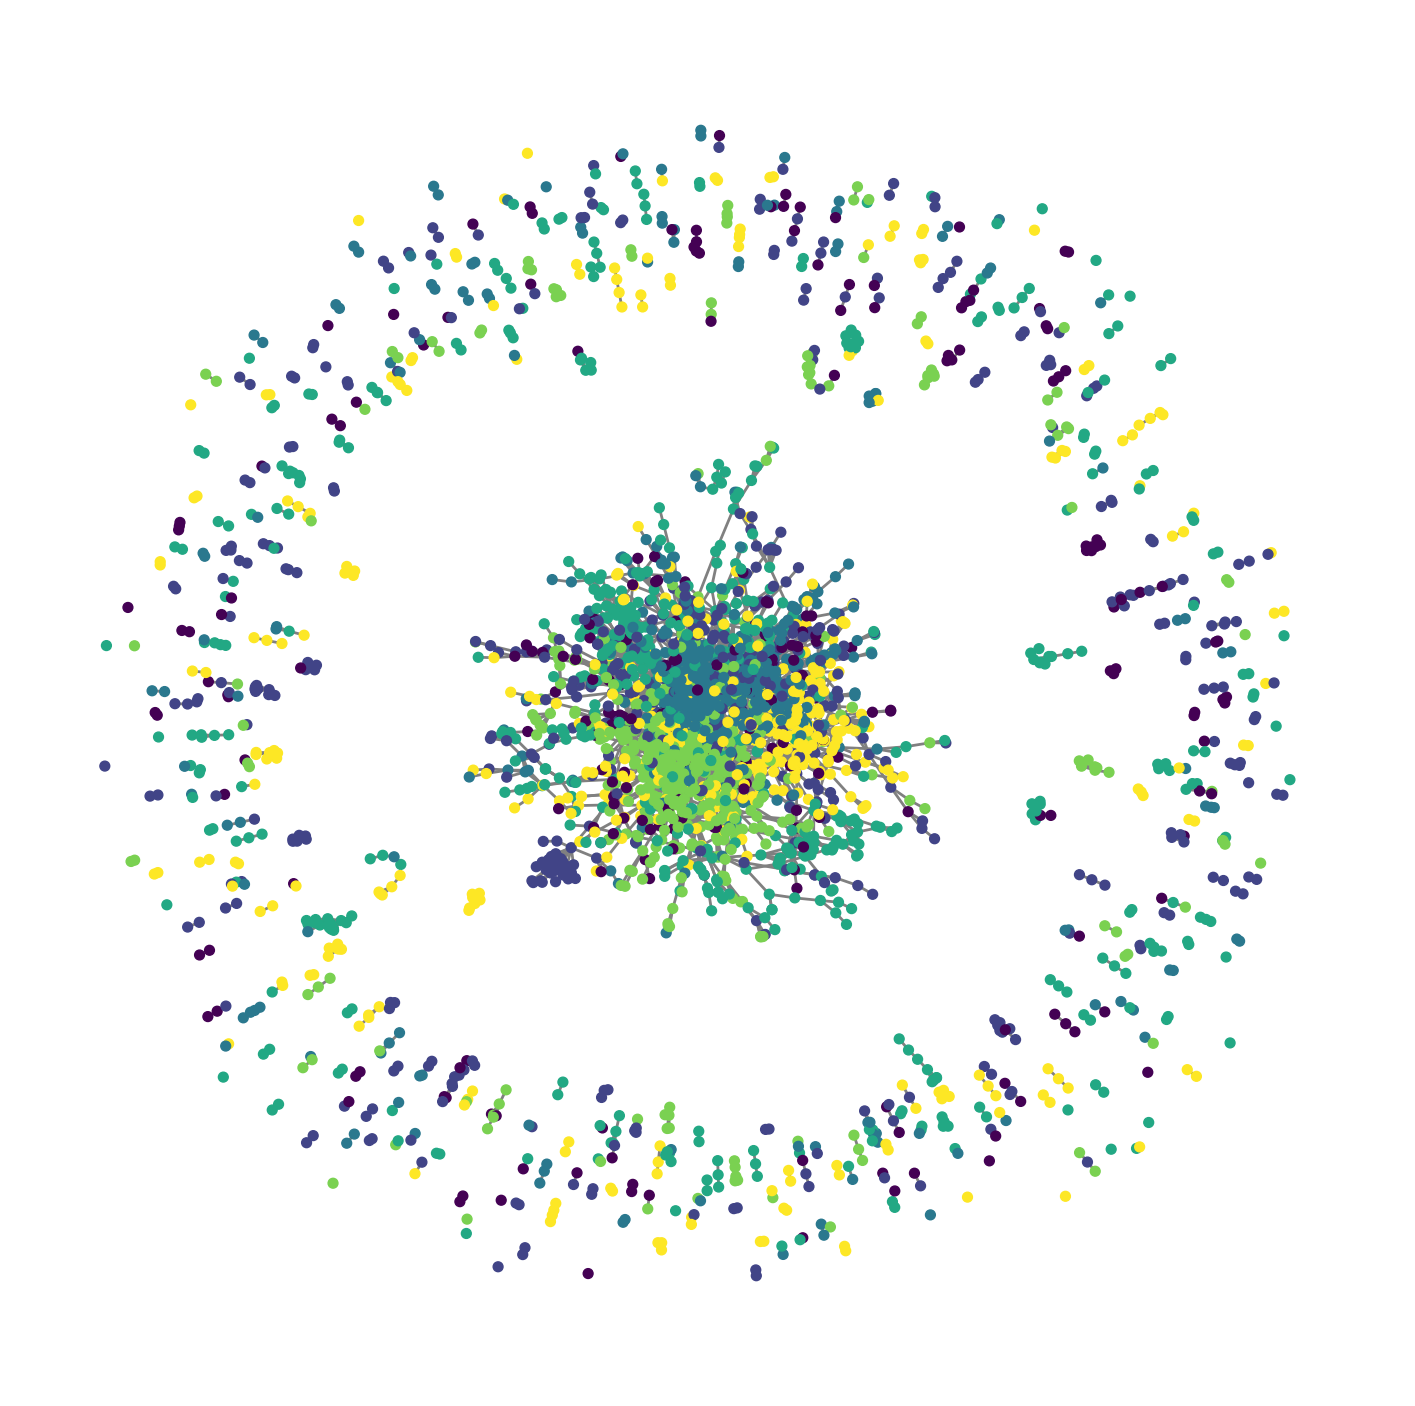

In [16]:
from torch_geometric.utils import to_networkx

G = to_networkx(data, to_undirected=True)
plt.figure(figsize=(18,18))
plt.axis('off')
nx.draw_networkx(G,
                pos=nx.spring_layout(G, seed=0),
                with_labels=False,
                node_size=50,
                node_color=data.y,
                width=2,
                edge_color="grey"
                )
plt.show()

## Plot node degrees

In [17]:
data.edge_index[0]

tensor([   0,    1,    1,  ..., 3324, 3325, 3326])

<BarContainer object of 32 artists>

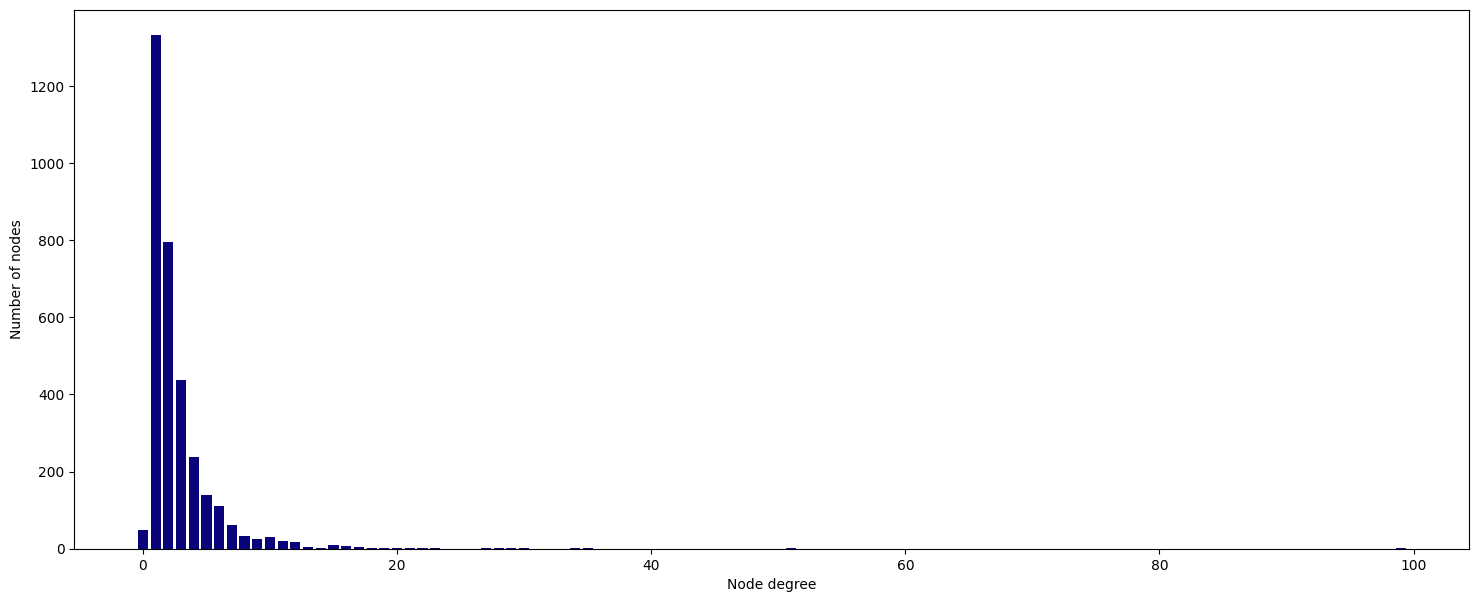

In [18]:
from torch_geometric.utils import degree
from collections import Counter

# Get list of degrees for each node
degrees = degree(data.edge_index[0]).numpy()

# Count the number of nodes for each degree
numbers = Counter(degrees)

# Bar plot
fig, ax = plt.subplots(figsize=(18, 7))
ax.set_xlabel('Node degree')
ax.set_ylabel('Number of nodes')
plt.bar(numbers.keys(),
        numbers.values(),
        color='#0A047A')

# GAT and GCN models

In [19]:
import torch.nn.functional as F
from torch.nn import Linear, Dropout
from torch_geometric.nn import GCNConv, GATv2Conv


class GCN(torch.nn.Module):
  """Graph Convolutional Network"""
  def __init__(self, dim_in, dim_h, dim_out):
    super().__init__()
    self.gcn1 = GCNConv(dim_in, dim_h)
    self.gcn2 = GCNConv(dim_h, dim_out)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.01,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.5, training=self.training)
    h = self.gcn1(h, edge_index)
    h = torch.relu(h)
    h = F.dropout(h, p=0.5, training=self.training)
    h = self.gcn2(h, edge_index)
    return h, F.log_softmax(h, dim=1)


class GAT(torch.nn.Module):
  """Graph Attention Network"""
  def __init__(self, dim_in, dim_h, dim_out, heads=8):
    super().__init__()
    self.gat1 = GATv2Conv(dim_in, dim_h, heads=heads)
    self.gat2 = GATv2Conv(dim_h*heads, dim_out, heads=1)
    self.optimizer = torch.optim.Adam(self.parameters(),
                                      lr=0.005,
                                      weight_decay=5e-4)

  def forward(self, x, edge_index):
    h = F.dropout(x, p=0.6, training=self.training)
    h = self.gat1(x, edge_index)
    h = F.elu(h)
    h = F.dropout(h, p=0.6, training=self.training)
    h = self.gat2(h, edge_index)
    return h, F.log_softmax(h, dim=1)



In [33]:
gat(data.x, data.edge_index)

(tensor([[-1.0805, -0.7957, -0.9349,  6.0860, -1.8740, -1.3672],
         [-1.2113,  6.1776, -0.1523, -1.9512, -1.5151, -1.2835],
         [-1.6573, -2.0105, -1.6763, -0.8941, -0.9254,  6.7890],
         ...,
         [-0.7726, -0.5140,  1.6876,  3.6373, -1.8586, -1.4141],
         [ 0.9354,  1.5865,  1.5471, -1.3615, -1.0242, -1.7438],
         [-0.1898, -0.9938, -1.8782, -2.3573, -1.7120,  6.5106]],
        grad_fn=<AddBackward0>),
 tensor([[-7.1701e+00, -6.8853e+00, -7.0246e+00, -3.6136e-03, -7.9636e+00,
          -7.4569e+00],
         [-7.3926e+00, -3.7196e-03, -6.3336e+00, -8.1325e+00, -7.6964e+00,
          -7.4647e+00],
         [-8.4478e+00, -8.8010e+00, -8.4668e+00, -7.6846e+00, -7.7159e+00,
          -1.4819e-03],
         ...,
         [-4.5761e+00, -4.3174e+00, -2.1159e+00, -1.6612e-01, -5.6620e+00,
          -5.2175e+00],
         [-1.6236e+00, -9.7251e-01, -1.0119e+00, -3.9205e+00, -3.5832e+00,
          -4.3028e+00],
         [-6.7028e+00, -7.5068e+00, -8.3912e+00, -8.8

In [20]:
def accuracy(pred_y, y):
    """Calculate accuracy."""
    return ((pred_y == y).sum() / len(y)).item()

def train(model, data):
    """Train a GNN model and return the trained model."""
    criterion = torch.nn.CrossEntropyLoss()
    optimizer = model.optimizer
    epochs = 200

    model.train()
    for epoch in range(epochs+1):
        # Training
        optimizer.zero_grad()
        _, out = model(data.x, data.edge_index)
        loss = criterion(out[data.train_mask], data.y[data.train_mask])
        acc = accuracy(out[data.train_mask].argmax(dim=1), data.y[data.train_mask])
        loss.backward()
        optimizer.step()

        # Validation
        val_loss = criterion(out[data.val_mask], data.y[data.val_mask])
        val_acc = accuracy(out[data.val_mask].argmax(dim=1), data.y[data.val_mask])

        # Print metrics every 10 epochs
        if(epoch % 10 == 0):
            print(f'Epoch {epoch:>3} | Train Loss: {loss:.3f} | Train Acc: '
                  f'{acc*100:>6.2f}% | Val Loss: {val_loss:.2f} | '
                  f'Val Acc: {val_acc*100:.2f}%')
          
    return model

def test(model, data):
    """Evaluate the model on test set and print the accuracy score."""
    model.eval()
    _, out = model(data.x, data.edge_index)
    acc = accuracy(out.argmax(dim=1)[data.test_mask], data.y[data.test_mask])
    return acc

# Train GCN

In [21]:
%%time

# Create GCN model
gcn = GCN(dataset.num_features, 16, dataset.num_classes)
print(gcn)

# Train
train(gcn, data)

# Test
acc = test(gcn, data)
print(f'\nGCN test accuracy: {acc*100:.2f}%\n')

GCN(
  (gcn1): GCNConv(3703, 16)
  (gcn2): GCNConv(16, 6)
)
Epoch   0 | Train Loss: 1.794 | Train Acc:  15.00% | Val Loss: 1.80 | Val Acc: 13.80%
Epoch  10 | Train Loss: 0.447 | Train Acc:  91.67% | Val Loss: 1.32 | Val Acc: 54.20%
Epoch  20 | Train Loss: 0.141 | Train Acc:  95.83% | Val Loss: 1.29 | Val Acc: 57.20%
Epoch  30 | Train Loss: 0.072 | Train Acc: 100.00% | Val Loss: 1.58 | Val Acc: 54.80%
Epoch  40 | Train Loss: 0.052 | Train Acc:  99.17% | Val Loss: 1.42 | Val Acc: 60.80%
Epoch  50 | Train Loss: 0.074 | Train Acc:  98.33% | Val Loss: 1.52 | Val Acc: 58.80%
Epoch  60 | Train Loss: 0.089 | Train Acc:  98.33% | Val Loss: 1.62 | Val Acc: 56.20%
Epoch  70 | Train Loss: 0.089 | Train Acc:  97.50% | Val Loss: 1.56 | Val Acc: 56.80%
Epoch  80 | Train Loss: 0.061 | Train Acc:  99.17% | Val Loss: 1.55 | Val Acc: 56.20%
Epoch  90 | Train Loss: 0.042 | Train Acc: 100.00% | Val Loss: 1.63 | Val Acc: 56.80%
Epoch 100 | Train Loss: 0.044 | Train Acc: 100.00% | Val Loss: 1.54 | Val Acc: 5

# Train GAT


In [22]:
%%time

# Create GAT model
gat = GAT(dataset.num_features, 8, dataset.num_classes)
print(gat)

# Train
train(gat, data)

# Test
acc = test(gat, data)
print(f'\nGAT test accuracy: {acc*100:.2f}%\n')

GAT(
  (gat1): GATv2Conv(3703, 8, heads=8)
  (gat2): GATv2Conv(64, 6, heads=1)
)
Epoch   0 | Train Loss: 1.818 | Train Acc:  11.67% | Val Loss: 1.81 | Val Acc: 15.00%
Epoch  10 | Train Loss: 0.133 | Train Acc:  96.67% | Val Loss: 1.06 | Val Acc: 66.00%
Epoch  20 | Train Loss: 0.014 | Train Acc: 100.00% | Val Loss: 1.14 | Val Acc: 65.20%
Epoch  30 | Train Loss: 0.004 | Train Acc: 100.00% | Val Loss: 1.23 | Val Acc: 65.00%
Epoch  40 | Train Loss: 0.004 | Train Acc: 100.00% | Val Loss: 1.21 | Val Acc: 67.00%
Epoch  50 | Train Loss: 0.006 | Train Acc: 100.00% | Val Loss: 1.15 | Val Acc: 66.40%
Epoch  60 | Train Loss: 0.009 | Train Acc: 100.00% | Val Loss: 1.15 | Val Acc: 67.20%
Epoch  70 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 1.20 | Val Acc: 66.20%
Epoch  80 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 1.14 | Val Acc: 66.60%
Epoch  90 | Train Loss: 0.007 | Train Acc: 100.00% | Val Loss: 1.14 | Val Acc: 67.40%
Epoch 100 | Train Loss: 0.008 | Train Acc: 100.00% | Val Lo

# t-SNE plots


In [24]:
from sklearn.manifold import TSNE

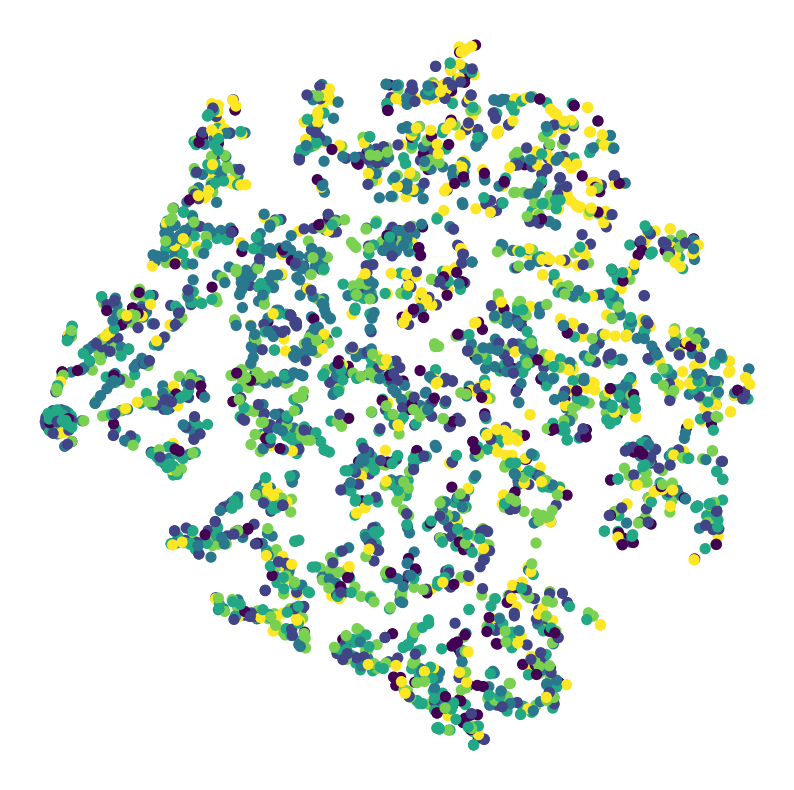

In [31]:
# Initialize new untrained model
untrained_gcn = GCN(dataset.num_features, 8, dataset.num_classes)

# Get embeddings
h, _ = untrained_gcn(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

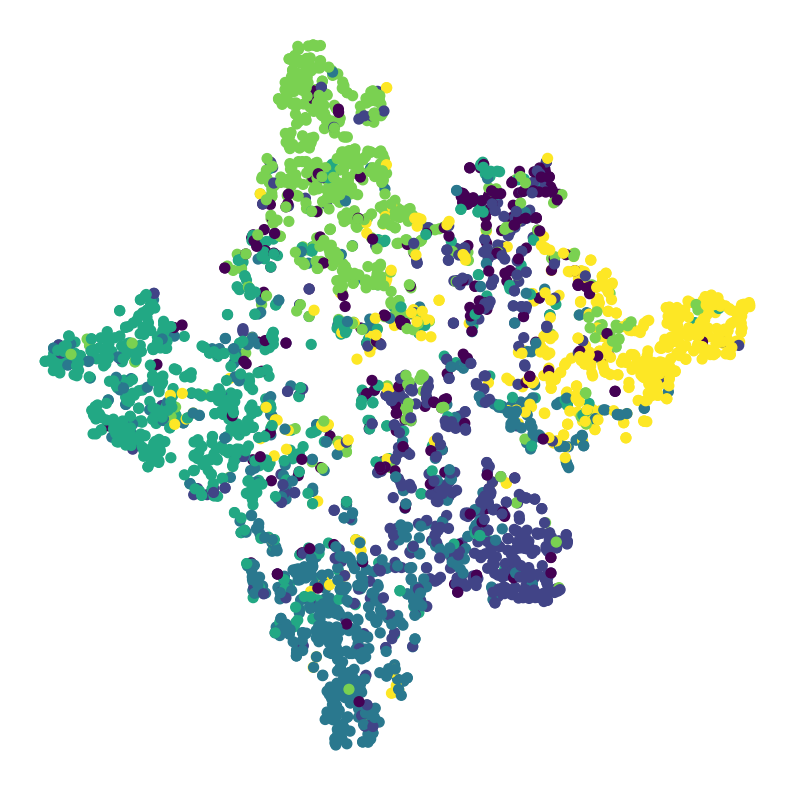

In [29]:
# Get embeddings
h, _ = gcn(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

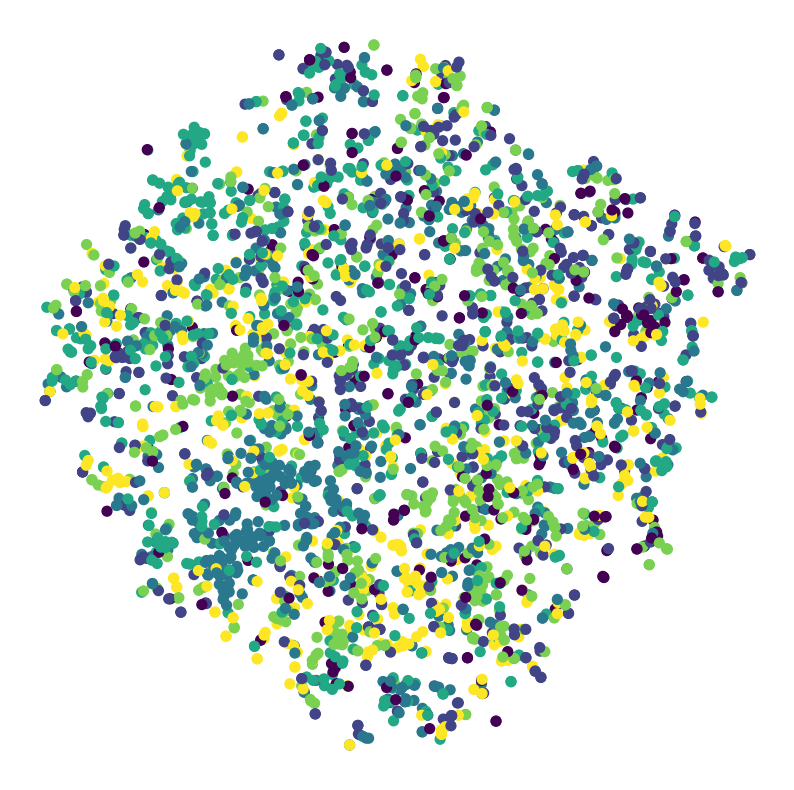

In [23]:
# Initialize new untrained model
untrained_gat = GAT(dataset.num_features, 8, dataset.num_classes)

# Get embeddings
h, _ = untrained_gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

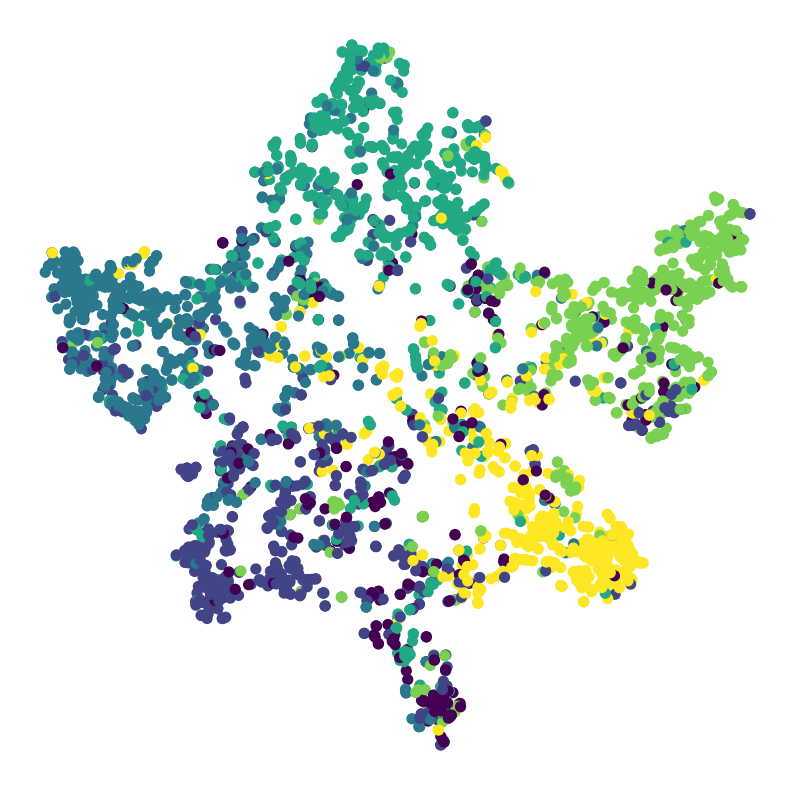

In [25]:
# Get embeddings
h, _ = gat(data.x, data.edge_index)

# Train TSNE
tsne = TSNE(n_components=2, learning_rate='auto',
         init='pca').fit_transform(h.detach())

# Plot TSNE
plt.figure(figsize=(10, 10))
plt.axis('off')
plt.scatter(tsne[:, 0], tsne[:, 1], s=50, c=data.y)
plt.show()

# Plot accuracy for each node degree

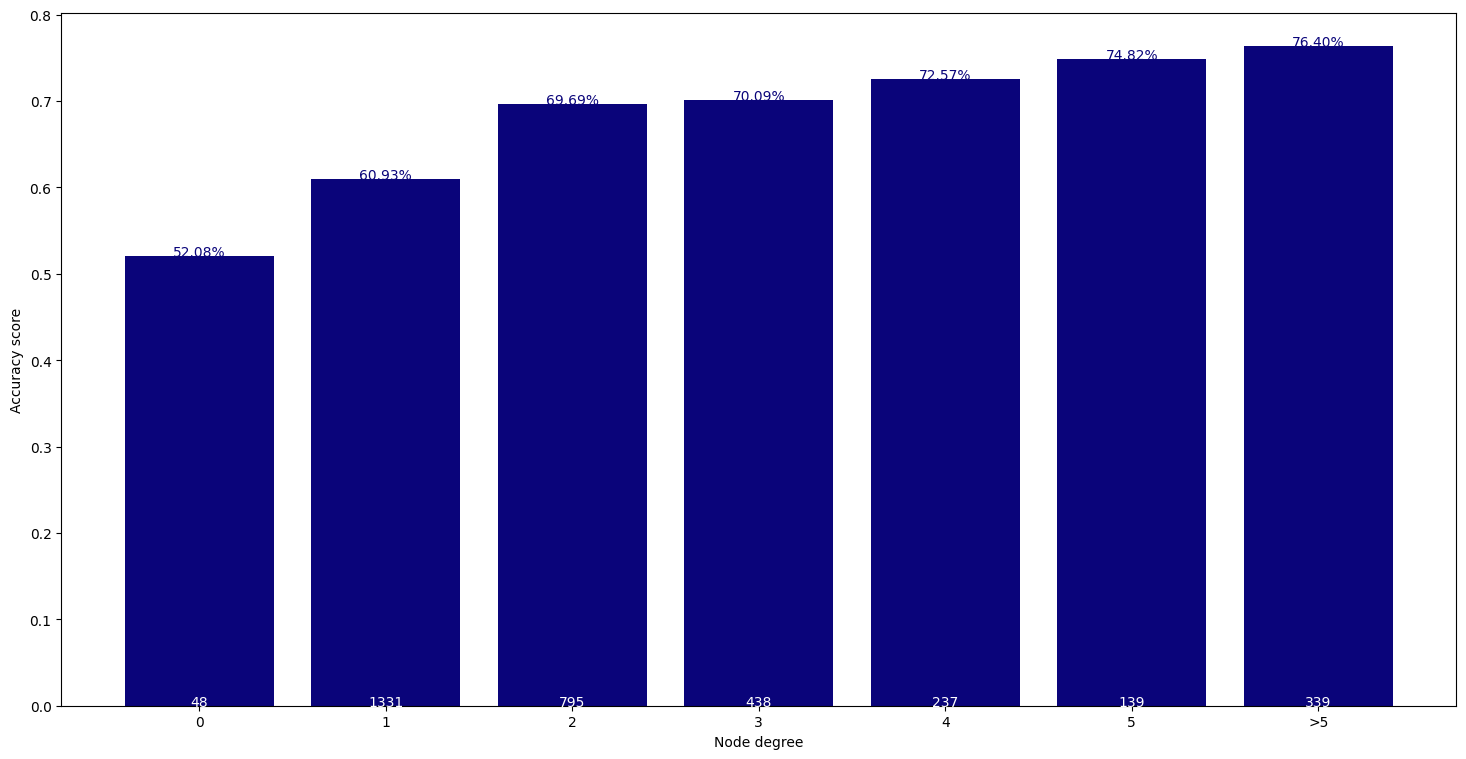

In [30]:
# Get model's classifications
_, out = gcn(data.x, data.edge_index)

# Calculate the degree of each node
degrees = degree(data.edge_index[0]).numpy()

# Store accuracy scores and sample sizes
accuracies = []
sizes = []

# Accuracy for degrees between 0 and 5
for i in range(0, 6):
  mask = np.where(degrees == i)[0]
  accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
  sizes.append(len(mask))

# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

# Bar plot
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0','1','2','3','4','5','>5'],
        accuracies,
        color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%',
             ha='center', color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i],
             ha='center', color='white')

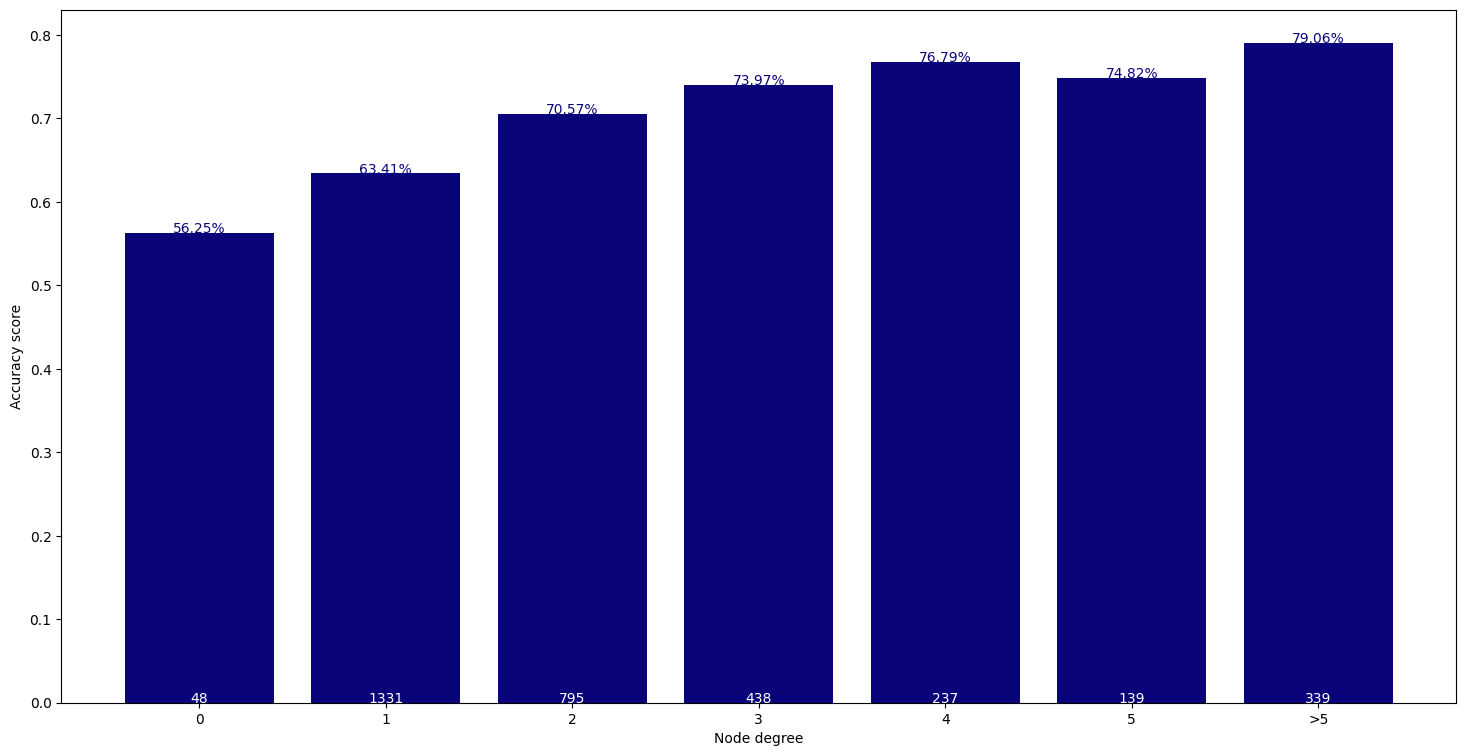

In [26]:
# Get model's classifications
_, out = gat(data.x, data.edge_index)

# Calculate the degree of each node
degrees = degree(data.edge_index[0]).numpy()

# Store accuracy scores and sample sizes
accuracies = []
sizes = []

# Accuracy for degrees between 0 and 5
for i in range(0, 6):
  mask = np.where(degrees == i)[0]
  accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
  sizes.append(len(mask))

# Accuracy for degrees > 5
mask = np.where(degrees > 5)[0]
accuracies.append(accuracy(out.argmax(dim=1)[mask], data.y[mask]))
sizes.append(len(mask))

# Bar plot
fig, ax = plt.subplots(figsize=(18, 9))
ax.set_xlabel('Node degree')
ax.set_ylabel('Accuracy score')
plt.bar(['0','1','2','3','4','5','>5'],
        accuracies,
        color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i], f'{accuracies[i]*100:.2f}%',
             ha='center', color='#0A047A')
for i in range(0, 7):
    plt.text(i, accuracies[i]//2, sizes[i],
             ha='center', color='white')